# Analysis

## Build corpus

In [4]:
from xml.etree import ElementTree as ET

wiki_fname = 'kowiki-latest-pages-articles.xml'

In [5]:
import re

def clean_text(text):    
    # Common
    text = re.sub("(?s)<ref>.+?</ref>", "", text) # remove reference links
    text = re.sub("(?s)<[^>]+>", "", text) # remove html tags
    text = re.sub("&[a-z]+;", "", text) # remove html entities
    text = re.sub("(?s){{.+?}}", "", text) # remove markup tags
    text = re.sub("(?s){.+?}", "", text) # remove markup tags
    text = re.sub("(?s)\[\[([^]]+\|)", "", text) # remove link target strings
    text = re.sub("(?s)\[\[([^]]+\:.+?]])", "", text) # remove media links
    
    text = re.sub("[']{5}", "", text) # remove italic+bold symbols
    text = re.sub("[']{3}", "", text) # remove bold symbols
    text = re.sub("[']{2}", "", text) # remove italic symbols
    
    text = re.sub(u"[^\s\r\n가-힣.?!]", " ", text) # Replace unacceptable characters with a space.
    text = re.sub('([.?!]){2,}', '\\1', text) # remove repeated punctuation
    text = re.sub('\s[.?!]\s', '', text) # remove isolated punctuation
    
    # Common
    text = re.sub("\s{2,}", " ", text) # Squeeze spaces.
    return text

In [10]:
def sentence_segment(text):
    '''
    Args:
      text: A string. A unsegmented paragraph.
    
    Returns:
      A list of sentences.
    '''
    return re.split('([.?!])?[\n]+|[.?!] ', text)

In [11]:
from konlpy.tag import Mecab

mecab = Mecab()
def word_segment(text):
    return [word for word, _ in mecab.pos(text)]

In [49]:
from tqdm import tqdm

ns = '{http://www.mediawiki.org/xml/export-0.10/}'
with open(f'./data/{wiki_fname.split("-")[0]}_corpus.txt', 'w', encoding='utf-8') as fout:
    for _, elem in tqdm(ET.iterparse(f'./data/{wiki_fname}')):
        try:
            tag = elem.tag.replace(ns, '')
            if tag == 'text':
                running_text = clean_text(elem.text)
                sents = sentence_segment(running_text)
                for sent in sents:
                    if sent:
                        words = word_segment(sent)
                        if len(words) > 10:
                            fout.write(' '.join(words) + '\n')
        except:
            continue
        elem.clear()

25979812it [30:56, 13991.10it/s]


## Make wor2vec

In [4]:
from gensim.models import Word2Vec

min_count = 5
window_size = 5
num_neg = 15
vector_size = 300

print('Making sentences as list...')
sents = []
corpus_fname = 'kowiki_corpus.txt'

with open(f'./data/{corpus_fname}', 'r', encoding='utf8') as fin:
    line = fin.readline()
    while line:
        words = line.split()
        sents.append(words)
        line = fin.readline()

print('Making word vectors...')
w2v_model = Word2Vec(sents, vector_size=vector_size, min_count=min_count, negative=num_neg, window=window_size)

w2v_model.save('./models/kowiki-neg-300.bin')

Making sentences as list...
Making word vectors...


In [13]:
w2v_model.wv.most_similar('독감')

[('인플루엔자', 0.7366062998771667),
 ('홍역', 0.6661979556083679),
 ('콜레라', 0.652269721031189),
 ('출혈열', 0.648910641670227),
 ('유행병', 0.6479013562202454),
 ('전염병', 0.6393334269523621),
 ('뎅기열', 0.6355220079421997),
 ('대유행', 0.6307356357574463),
 ('말라리아', 0.6306702494621277),
 ('광견병', 0.6233310103416443)]

In [14]:
w2v_kv = w2v_model.wv
w2v_kv.save('./models/kowiki-neg-300.kv')

## Extract "flu-related" words

In [1]:
from gensim.models import KeyedVectors

kv_fname = 'kowiki-neg-300.kv'
w2v_kv = KeyedVectors.load(f'./models/{kv_fname}')

In [3]:
w2v_kv.most_similar_cosmul(positive=['독감', '증상'], topn=10)

[('질병', 0.6456781029701233),
 ('합병증', 0.6416015028953552),
 ('패혈증', 0.6396576166152954),
 ('피부병', 0.6389033198356628),
 ('황달', 0.637260377407074),
 ('매독', 0.6342878341674805),
 ('기관지염', 0.6325851678848267),
 ('폐렴', 0.6323192715644836),
 ('급성', 0.6281660795211792),
 ('복통', 0.6278930902481079)]

In [21]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [4]:
from pytrends.request import TrendReq

flu_related_words = ['독감'] + [w for w, _ in w2v_kv.most_similar_cosmul(positive=['독감', '증상'], topn=1000)]
pyt = TrendReq(hl='ko-KR')

In [25]:
import pandas as pd
import time
from tqdm import tqdm

for i, keywords in tqdm(enumerate(chunks(flu_related_words, 5))):
    try:
        pyt.build_payload(keywords, timeframe='2017-01-01 2021-06-05', geo='KR')
        trends = pd.concat([trends, pyt.interest_over_time()], axis=1)
        trends.pop('isPartial')
        trends.to_csv('./data/독감+증상_google_trends.csv')
        time.sleep(5)
    except:
        print(i, keywords)
        break


199it [21:14,  6.40s/it]


In [31]:
trends

,독감,질병,합병증,패혈증,피부병,황달,매독,기관지염,폐렴,급성,...,성욕,뇌막,뇌일혈,에리트로포이에틴,원추각막,열대병,요법,마비저,손상,통풍
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,16,6,1,0,2,0,0,0,1,0,...,68,0,0,0,0,0,63,0,63,52
2017-01-08,10,6,1,1,1,0,0,0,1,0,...,55,0,0,0,4,0,52,0,37,61
2017-01-15,9,5,1,0,1,1,0,0,1,1,...,42,0,0,0,0,0,40,0,44,41
2017-01-22,3,4,1,1,2,0,0,0,1,1,...,40,0,0,0,0,0,31,0,35,29
2017-01-29,2,5,2,1,1,0,0,0,1,2,...,65,0,0,0,0,0,46,0,21,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-02,3,22,1,2,1,0,0,0,1,1,...,33,0,0,0,4,0,31,0,47,37
2021-05-09,3,33,2,1,0,0,0,0,1,1,...,39,0,0,0,0,0,40,0,34,35
2021-05-16,3,17,2,1,0,0,0,0,1,1,...,40,0,0,0,0,0,37,0,61,35


## Correlation between flu and google trends 

In [1]:
from tqdm import tqdm
import pandas as pd

flu_rate = pd.read_csv('./data/170101_210530_influenza.csv')
word_trends = pd.read_csv('./data/독감+증상_google_trends.csv')

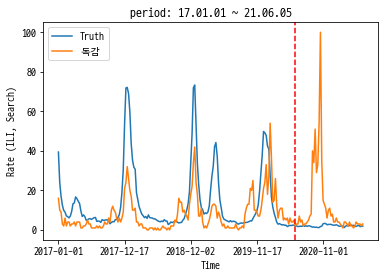

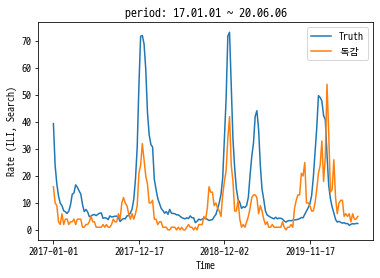

In [2]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'D2Coding'

# 17.01.01 ~ 21.06.05
plt.plot(flu_rate['ratio'], label='Truth')
plt.plot(word_trends['독감'], label='독감')
plt.axvline(len(flu_rate)-52, c='red', ls='--')
plt.xticks(range(0, 201, 50), [flu_rate['date'][i] for i in range(0, 201, 50)])
plt.title('period: 17.01.01 ~ 21.06.05')
plt.xlabel('Time')
plt.ylabel('Rate (ILI, Search)')
plt.legend()
plt.show()

# 17.01.01 ~ 20.06.06
plt.plot(flu_rate['ratio'][:-52], label='Truth')
plt.plot(word_trends['독감'][:-52], label='독감')
plt.xticks(range(0, 151, 50), [flu_rate['date'][i] for i in range(0, 151, 50)])
plt.title('period: 17.01.01 ~ 20.06.06')
plt.xlabel('Time')
plt.ylabel('Rate (ILI, Search)')
plt.legend()
plt.show()

In [3]:
flu_rate_rm1y = flu_rate[:-52] # remove 1 year
word_trends_rm1y = word_trends[:-52] # remove 1 year

In [4]:
def cross_corr(x, y, max_lag=0):
    '''
    Args:
        x (pandas.Series): fixed data
        y (pandas.Series): data to be shifted
    
    Returns:
        corr (pandas.Series): {0: XX.XX, 1: XX.XX, ..., max_lag: XX.XX}
    '''
    corr = {}
    for lag in range(max_lag+1):
        corr[lag] = x.corr(y.shift(lag))
    return pd.Series(corr)


In [5]:
word_trends_with_lag = {word: cross_corr(flu_rate_rm1y['ratio'], word_trends_rm1y[word], max_lag=12)
                         for word in tqdm(word_trends_rm1y.columns[1:])}

100%|██████████| 1001/1001 [00:05<00:00, 196.19it/s]


In [6]:
import numpy as np

corr_topn = [(word, corr[0]) for word, corr in word_trends_with_lag.items() if not np.isnan(corr[0])]
corr_topn.sort(key=(lambda x: x[1]), reverse=True)

In [7]:
corr_topn[:10]

[('독감', 0.6979971655966585),
 ('감기', 0.6057191438596866),
 ('몸살', 0.5889798823270904),
 ('기침', 0.3876285746258827),
 ('췌장', 0.3608778113287914),
 ('고열', 0.30212302788295675),
 ('탄저균', 0.29857257200851156),
 ('보균자', 0.29653042044449096),
 ('환각', 0.2515249085001921),
 ('용종', 0.2282457533134259)]

In [8]:
corr_topn_lag = []
for word, corr in word_trends_with_lag.items():
    try:
        lag = corr.argmax()
        max_corr = corr[lag]
        corr_topn_lag.append((word, max_corr, lag))
    except:
        continue # if all elements are NaN, continue

corr_topn_lag.sort(key=(lambda x: x[1]), reverse=True)

In [9]:
corr_topn_lag[:10]

[('독감', 0.6979971655966585, 0),
 ('감기', 0.6057191438596866, 0),
 ('몸살', 0.5889798823270904, 0),
 ('저체온증', 0.5415003240053498, 6),
 ('접종', 0.48151825584155167, 11),
 ('창궐', 0.41881283249748075, 4),
 ('흉부', 0.40158419376844445, 10),
 ('비염', 0.3977656109111145, 12),
 ('췌장', 0.3881219654022702, 7),
 ('기침', 0.3876285746258827, 0)]